Changing feature enginering

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [5]:
df_train = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/train.csv')
df_test = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/test.csv')
df_hist_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/historical_transactions_new.csv')
df_new_merchant_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/new_merchant_transactions_new.csv')

In [17]:
id=df_test[df_test.first_active_month.isnull()].card_id.values[0]
first_pur=df_hist_trans[df_hist_trans.card_id==id].sort_values('purchase_date').purchase_date.values[0]
df_test.loc[ind,'first_active_month']=first_pur[0:7] #'2017-03'
#df_test.to_csv('test_without_nan.csv',index=False)

In [46]:
train_month_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/train_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])
test_month_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/test_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])
hist_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/hist_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])
new_mech_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/new_mech_month_lag_0.csv',header=None,squeeze=True,parse_dates=[0])

In [228]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

I we can take weekofyear,day of week, weekend as extra parameter which I didn't. I am not sure if month diff is correct. Still confused about this issue

In [229]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [ ]:


df_hist_trans['month_diff'] = (hist_lag_0 - df_hist_trans['purchase_date']).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']
df_new_merchant_trans['month_diff'] = (new_mech_lag_0 - df_hist_trans['purchase_date']).dt.days)//30
df_new_merchant_trans['month_diff'] += df_new_merchant_trans['month_lag']


In [230]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days

df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']

df_hist_trans_group['hist_purchase_date_uptonow'] = (hist_lag_0 - df_hist_trans_group['hist_purchase_date_max']).dt.days


df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

2278

In [231]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']

df_hist_trans_group['new_hist_purchase_date_uptonow'] = (new_mech_lag_0 - df_hist_trans_group['new_hist_purchase_date_max']).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

77

In [232]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.557410,-0.630699,54.0,2.347826,226.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.557410,-0.571577,56.0,9.333333,256.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.537051,-0.630699,0.0,0.000000,227.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.546090,-0.571577,41.0,5.857143,237.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.546143,-0.554616,57.0,1.583333,227.0


In [233]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [234]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)


In [235]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [236]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66422	valid_1's rmse: 3.73379
[200]	training's rmse: 3.58687	valid_1's rmse: 3.70331
[300]	training's rmse: 3.53934	valid_1's rmse: 3.69091
[400]	training's rmse: 3.50309	valid_1's rmse: 3.68399
[500]	training's rmse: 3.47291	valid_1's rmse: 3.67933
[600]	training's rmse: 3.44712	valid_1's rmse: 3.67555
[700]	training's rmse: 3.42489	valid_1's rmse: 3.6734
[800]	training's rmse: 3.40462	valid_1's rmse: 3.67203
[900]	training's rmse: 3.3868	valid_1's rmse: 3.67126
[1000]	training's rmse: 3.37024	valid_1's rmse: 3.67072
[1100]	training's rmse: 3.35364	valid_1's rmse: 3.66976
[1200]	training's rmse: 3.33772	valid_1's rmse: 3.66975
Early stopping, best iteration is:
[1113]	training's rmse: 3.35151	valid_1's rmse: 3.66968
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67254	valid_1's rmse: 3.70232
[200]	training's rmse: 3.59797	valid_1's rmse: 3.6663

3.6542466337241271

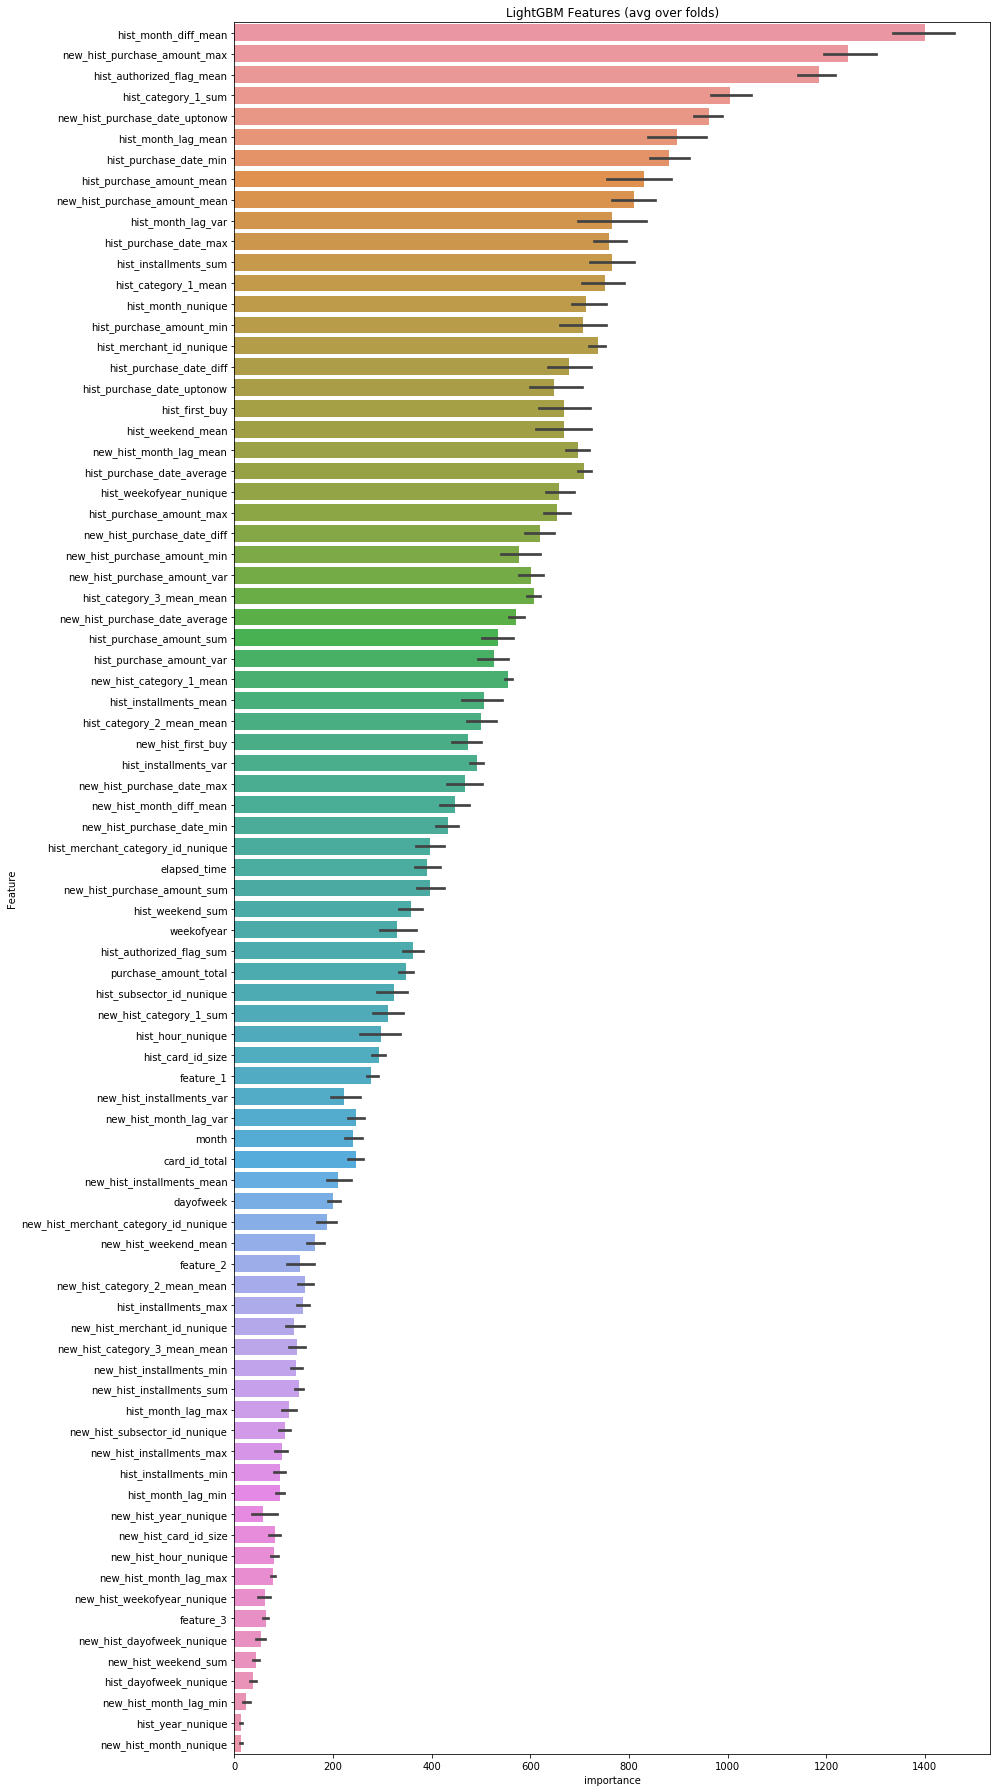

In [237]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances_feature_eng_2.png')

In [238]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("chau_feature_engineering_3.csv", index=False)

**To be continued ...**

In [243]:
best_features.groupby('Feature').mean().sort_values('importance',ascending=False).to_csv('feature_importance2.csv')